##Introduction
***We will be working on a dataset available in Kaggle: [cat-​and-​dog](https:/​/​www.​kaggle.​com/tongpython/​cat-​and-​dog).***

###Install Additional Libraroes

In [1]:
!pip install torch_summary
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import Libraries

In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from random import shuffle, seed
from glob import glob
from google.colab import files

import matplotlib.pyplot as plt
%matplotlib inline

seed(10)

##Make Kaggle setup

**You must upload your kaggle.json file**

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hassannassar10","key":"e1134f1aa40830f922dd27da1cedf5ff"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


#Download the data

In [5]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [6]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

##Build Data Loader Class

In [7]:
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs
    shuffle(self.fpaths)
    self.targets=[fpath.split('/')[-1].startswith('dog') \
                            for fpath in self.fpaths] # dog=1
  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1)\
                              .to(device).float(),\
                              torch.tensor([target]) \
                              .float().to(device)

tensor([1.], device='cuda:0')


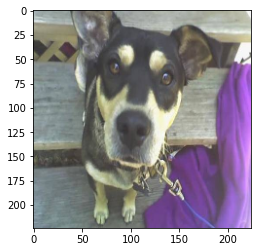

In [8]:
data = cats_dogs(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

##Build the model

In [9]:
def conv_layer(channels, num_filters, kernel_size, stride=1):
  return nn.Sequential(
  nn.Conv2d(channels, num_filters, kernel_size, stride),
  nn.ReLU(),
  nn.BatchNorm2d(num_filters),
  nn.MaxPool2d(2)
  )

def get_model():
  model = nn.Sequential(
  conv_layer(3, 64, 3),
  conv_layer(64, 512, 3),
  conv_layer(512, 512, 3),
  conv_layer(512, 512, 3),
  conv_layer(512, 512, 3),
  conv_layer(512, 512, 3),
  nn.Flatten(),
  nn.Linear(512, 1),
  nn.Sigmoid(),
  ).to(device)
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
  return model, loss_fn, optimizer

In [10]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3, 224, 224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [11]:
def get_data():
  train = cats_dogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, \
  drop_last = True)
  val = cats_dogs(test_data_dir)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, \
  drop_last = True)
  return trn_dl, val_dl

def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

###Define Accuracy function

In [12]:
@torch.no_grad()
def accuracy(x, y, model):
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

###Define the validation loss calculation function

In [13]:
@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

##Train for 5 epochs

In [14]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, \
    loss_fn)
    train_epoch_losses.append(batch_loss)
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)

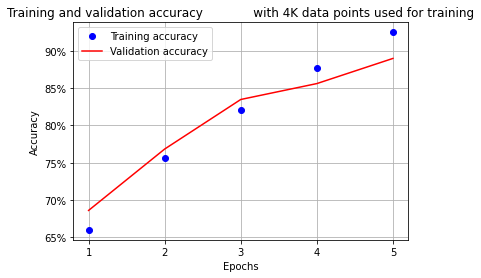

In [15]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
            with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                            for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

tensor([1.], device='cuda:0')


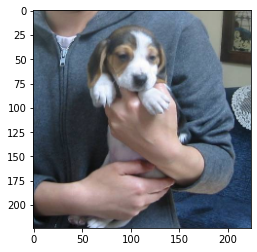

In [27]:
test_data = cats_dogs(test_data_dir)
im, label = test_data[100]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [28]:
pred = model(im[None])
print("True Label: ", label)
print("prediction:", pred)

True Label:  tensor([1.], device='cuda:0')
prediction: tensor([[0.8433]], device='cuda:0', grad_fn=<SigmoidBackward0>)
